# <font color='blue'> Bayesian Networks Tutorials
- https://pgmpy.org/detailed_notebooks/1.%20Introduction%20to%20Probabilistic%20Graphical%20Models.html

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.interactiveshell import InteractiveShell # 모든 명령어 출력
InteractiveShell.ast_node_interactivity = 'all'
import warnings
warnings.filterwarnings('ignore')

# 1. Introduction to Probabilitic Graphical Models
## 1.1. Contents
- What is machine learning
- Different ways of learning from data
- Why probabilistic graphical models
- Major types of PGMs

## 1.1.1. 1. What is machine learning

In [2]:
from sklearn import datasets
iris = datasets.load_iris()
X = iris.data[:, :2]  # we only take the first two features.
y = iris.target
data = pd.DataFrame(np.c_[X, y], columns = ['length', 'width', 'type'])
data.head()

,length,width,type
0,5.1,3.5,0.0
1,4.9,3.0,0.0
2,4.7,3.2,0.0
3,4.6,3.1,0.0
4,5.0,3.6,0.0


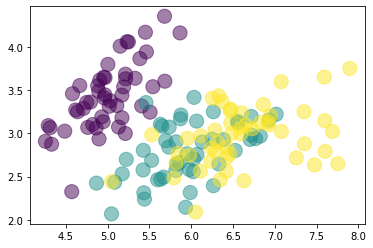

In [3]:
data_with_noise = data.iloc[:, :2] + np.random.normal(loc=0, scale=0.1, size=(150, 2))
plt.scatter(data_with_noise.length, data_with_noise.width, c=data.type, s=200, alpha=0.5)

array([[<AxesSubplot:title={'center':'length'}>,
        <AxesSubplot:title={'center':'width'}>],
       [<AxesSubplot:title={'center':'type'}>, <AxesSubplot:>]],
      dtype=object)

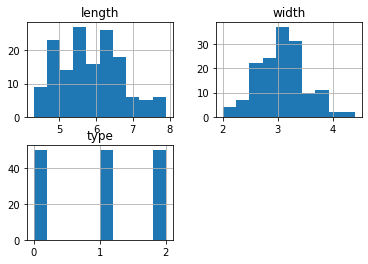

In [4]:
data.hist()

## 1.1.2. 2. Different ways of learning from data

## 빈도수는 결국 범주형으로 변환하여 각 변수의 범주형의 구간에 따라 어느 정도 범위에 있었는지 예측하는 것
### 실수를 모두 범주형으로 변환

,length,width,type
134,6,3,2
148,6,3,2
25,5,3,0
48,5,4,0
86,7,3,1
79,6,3,1
26,5,3,0
101,6,3,2
71,6,3,1
119,6,2,2


,length,width,type
0,5,4,0
1,5,3,0
2,5,3,0
3,5,3,0
4,5,4,0


array([[<AxesSubplot:title={'center':'length'}>,
        <AxesSubplot:title={'center':'width'}>],
       [<AxesSubplot:title={'center':'type'}>, <AxesSubplot:>]],
      dtype=object)

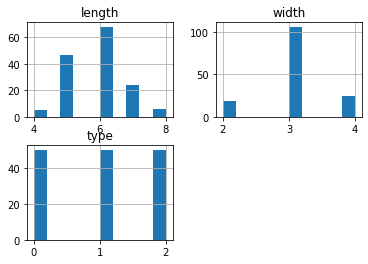

In [5]:
data= data.round().astype(int)
data.loc[[134, 148, 25, 48, 86, 79, 26, 101, 71, 119], :]
data.head()
data.hist()

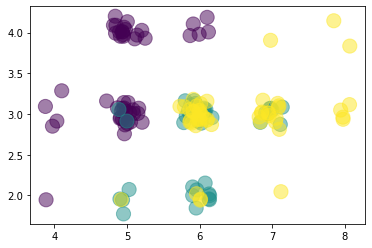

In [6]:
data_with_noise = data.iloc[:, :2] + np.random.normal(loc=0, scale=0.1, size=(150, 2))
plt.scatter(data_with_noise.length, data_with_noise.width, c=data.type, s=200, alpha=0.5)

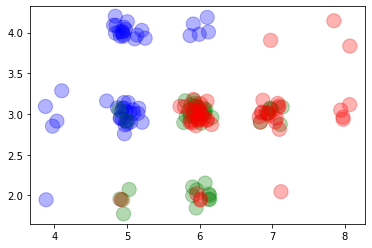

In [7]:
plt.scatter(data_with_noise.length, data_with_noise.width, c=[ "bgr"[k] for k in data.iloc[:,2] ], s=200, alpha=0.3)

## 의사결정 트리로 예측

In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data[['length', 'width']].values, data.type.values, test_size=0.2)

X_train.shape, X_test.shape, y_train.shape, y_test.shape 

classifier = DecisionTreeClassifier(max_depth=4)
classifier.fit(X_train, y_train)
classifier.predict(X_test)

classifier.score(X_test, y_test)

((120, 2), (30, 2), (120,), (30,))

DecisionTreeClassifier(max_depth=4)

array([2, 1, 1, 1, 0, 0, 1, 1, 0, 0, 2, 1, 0, 2, 0, 2, 1, 1, 1, 1, 2, 1,
       2, 0, 0, 0, 1, 1, 0, 1])

0.7

## 빈도수를 이용해서 예측 (단 변수의 값은 모두 범주형의 의미임)

Now moving on to our second approach using a probabilistic model. The most obvious way to do this classification task would be to compute a Joint Probability Distribution over all these variables and then marginalize and reduce over these according to our new data point to get the probabilities of classes.

In [9]:
data

,length,width,type
0,5,4,0
1,5,3,0
2,5,3,0
3,5,3,0
4,5,4,0
...,...,...,...
145,7,3,2
146,6,2,2
147,6,3,2
148,6,3,2


### random.seed에 따라 test데이터의 경우의 빈도(length와 width의)가 없는 경우는 error발생

In [10]:
np.random.seed(1024) # 재현가능
choice = np.random.choice(150, 120, replace=False)
no_choice = list(set(np.arange(0, 150)) - set(choice))

X_train, X_test = data.iloc[choice, :], data.iloc[no_choice, :]

X_train.shape, X_test.shape, y_train.shape, y_test.shape 

((120, 3), (30, 3), (120,), (30,))

In [11]:
#X_train, X_test = data[:120], data[120:]

In [12]:
# Computing the joint probability distribution over the training data
joint_prob = X_train.groupby(['length', 'width', 'type']).size() / 120
joint_prob

length  width  type
4       2      0       0.008333
        3      0       0.025000
5       2      1       0.033333
               2       0.008333
        3      0       0.158333
               1       0.008333
        4      0       0.091667
6       2      1       0.058333
               2       0.025000
        3      1       0.175000
               2       0.175000
        4      0       0.033333
7       2      2       0.008333
        3      1       0.041667
               2       0.108333
        4      2       0.008333
8       3      2       0.016667
        4      2       0.016667
dtype: float64

In [13]:
# Predicting values

# Selecting just the feature variables.
X_test_features = X_test.iloc[:, :2].values
X_test_actual_results = X_test.iloc[:, 2].values

X_test_features.shape, X_test_actual_results.shape

((30, 2), (30,))

In [14]:
predicted_values = []
for i in X_test_features:
    predicted_values.append(joint_prob[i[0], i[1]].idxmax())

predicted_values = np.array(predicted_values)
predicted_values

# Comparing results with the actual data.
predicted_values == X_test_actual_results

score = (predicted_values == X_test_actual_results).sum() / 30
print(score)

array([0, 2, 1, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 2, 1, 1,
       1, 2, 2, 1, 1, 1, 1, 2], dtype=int64)

array([ True,  True, False,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True, False,  True,  True,  True, False, False,  True,  True,
        True, False,  True])

0.7666666666666667


## 1.1.3. Why Probabilistic Graphical Models

In [15]:
print('Prior Probability')
data.type.value_counts(normalize=True)

Prior Probability


0    0.333333
1    0.333333
2    0.333333
Name: type, dtype: float64

In the previous example we saw how Bayesian Inference works. We construct a Joint Distribution over the data and then condition on the observed variable to compute the posterior distribution. And then we query on this posterior distribution to predict the values of new data points.

But the problem with this method is that the Joint Probability Distribution is exponential to the number of states (cardinality) of each variable. So, for problems having a lot of features or having high cardinality of features, inference becomes a difficult task because of computational limitations. For example, for 10 random variables each having 10 states, the size of the Joint Distribution would be 10^10.

### Proababilistic Graphical Models (PGM): 
PGM is a technique of compactly representing Joint Probability Distribution over random variables by exploiting the (conditional) independencies between the variables. PGM also provides us methods for efficiently doing inference over these joint distributions.

<img src='https://pgmpy.org/_images/detailed_notebooks_1._Introduction_to_Probabilistic_Graphical_Models_20_0.png' width = 1000, height=300>

<img src='https://pgmpy.org/_images/detailed_notebooks_1._Introduction_to_Probabilistic_Graphical_Models_22_0.png' width = 700, height=700>

## 1.1.3.1. Types of Graphical Models
There are mainly 2 types of graphical models:

### 1. Bayesian Models: 
A Bayesian Model consists of a directed graph and Conditional Probability Distributions(CPDs) associated with each of the node. Each CPD is of the form P(node | parents(node)) where parents(node) are the parents of the node in the graph structure.

### 2. Markov Models: 
A Markov Models consists of an undirected graph and are parameterized by Factors. Factors represent how much 2 or more variables agree with each other.

# End